# 3.Time Series Forecasting Model Development

This notebook covers the **modeling stage** of the Predict+Optimize Renewable Energy project.
The objective is to train, validate, and evaluate time series forecasting models using
feature-engineered datasets produced in the previous pipeline step.

Scope of this notebook:
- Load finalized modeling datasets
- Train forecasting models
- Evaluate performance on validation data
- Generate predictions for the test period (November 2020)
- Save prediction artifacts for downstream analysis and reporting

This notebook focuses **only on forecasting**, not optimization.

**Modeling Strategy**

Forecasting Target:
The target variable is:
- `value`: measured energy demand (buildings) or solar production (solar series)

Modeling Paradigm:
- Supervised regression
- One-step-ahead forecasting
- Lag-based autoregressive features
- Exogenous variables (ERA5 weather features)

Dataset Split:
- **Training**: Phase 1 (Jan 2016 – Sep 2020)
- **Validation**: Phase 2 (October 2020)
- **Test**: Final Test (November 2020)

Evaluation Metric:
- Mean Absolute Error (MAE)
- Root Mean Squared Error (RMSE)

These metrics are robust and interpretable for energy forecasting problems.


## 3.1 Import Libraries

In [1]:
# -------------------------------
# IMPORT LIBRARIES
# -------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBRegressor, callback
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pickle

## 3.2 Load Dataset

In [2]:
# -------------------------------
# LOAD FILTERED TRAIN & VALIDATION DATA
# -------------------------------
train_df = pd.read_csv("../data/modeling/train.csv", parse_dates=["timestamp"])
val_df   = pd.read_csv("../data/modeling/validation.csv", parse_dates=["timestamp"])

print(f"Train shape: {train_df.shape}")
print(f"Validation shape: {val_df.shape}")

Train shape: (472707, 19)
Validation shape: (22648, 19)


## 3.3 Define Features & Target

In [3]:
# -------------------------------
# DEFINE FEATURES & TARGET
# -------------------------------
# Target is 'value'; all other columns except 'timestamp' and 'value' are features

target_col = "value"
feature_cols = [col for col in train_df.columns if col not in ["timestamp", "value", "series_id"]]

X_train = train_df[feature_cols]
y_train = train_df[target_col]

X_val = val_df[feature_cols]
y_val_actual = val_df[target_col]

## 3.4 LigthGBM Training & Evaluation

In [4]:
# -------------------------------
# PREPARE LIGHTGBM DATASETS
# -------------------------------
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_val   = lgb.Dataset(X_val, label=y_val_actual, reference=lgb_train)

# -------------------------------
# DEFINE MODEL PARAMETERS
# -------------------------------
lgb_params = {
    "objective": "regression",
    "metric": "rmse",
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 31,
    "max_depth": 10,
    "n_jobs": -1,
    "seed": 42,
    "verbose": -1
}

# -------------------------------
# TRAIN MODEL
# -------------------------------
evals_result = {}
# Correct way for all LightGBM versions
lgb_model = lgb.train(
    lgb_params,
    lgb_train,
    num_boost_round=1000,
    valid_sets=[lgb_train, lgb_val],
    valid_names=["train", "val"],
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=50)]
)

# -------------------------------
# VALIDATION
# -------------------------------
y_pred_lgb = lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration)

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_val_actual, y_pred_lgb))
print(f"Validation RMSE: {rmse:.4f}")

# Compute MAE
mae = mean_absolute_error(y_val_actual, y_pred_lgb)
print(f"Validation MAE: {mae:.4f}")

# R² score
r2 = r2_score(y_val_actual, y_pred_lgb)
print(f"Validation R² score: {r2:.4f}")

Training until validation scores don't improve for 50 rounds
[50]	train's rmse: 33.5478	val's rmse: 17.8952
[100]	train's rmse: 21.7869	val's rmse: 11.3876
[150]	train's rmse: 19.8499	val's rmse: 11.2546
[200]	train's rmse: 18.4076	val's rmse: 11.4703
Early stopping, best iteration is:
[150]	train's rmse: 19.8499	val's rmse: 11.2546
Validation RMSE: 11.2546
Validation MAE: 2.4579
Validation R² score: 0.9913


## 3.5 XGBoost Training & Evaluation

In [5]:
# Convert to DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dval   = xgb.DMatrix(X_val, label=y_val_actual)

xgb_params = {
    "objective": "reg:squarederror",
    "learning_rate": 0.05,
    "max_depth": 6,
    "eval_metric": "rmse"
}

evals = [(dtrain, "train"), (dval, "val")]

xgb_model = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=50
)

# Predict
y_pred_xgb = xgb_model.predict(dval)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_val_actual, y_pred_xgb))
mae = mean_absolute_error(y_val_actual, y_pred_xgb)
r2 = r2_score(y_val_actual, y_pred_xgb)

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_val_actual, y_pred_xgb))
print(f"Validation RMSE: {rmse:.4f}")

# Compute MAE
mae = mean_absolute_error(y_val_actual, y_pred_xgb)
print(f"Validation MAE: {mae:.4f}")

# R² score
r2 = r2_score(y_val_actual, y_pred_xgb)
print(f"Validation R² score: {r2:.4f}")

[0]	train-rmse:276.67970	val-rmse:167.43720
[50]	train-rmse:28.35418	val-rmse:14.74802
[100]	train-rmse:14.80654	val-rmse:6.92102
[150]	train-rmse:13.44516	val-rmse:6.72294
[200]	train-rmse:12.63957	val-rmse:6.63152
[250]	train-rmse:11.96769	val-rmse:6.62330
[300]	train-rmse:11.50511	val-rmse:6.53207
[350]	train-rmse:11.13347	val-rmse:6.49606
[400]	train-rmse:10.82813	val-rmse:6.44544
[450]	train-rmse:10.57825	val-rmse:6.37758
[500]	train-rmse:10.34457	val-rmse:6.35114
[550]	train-rmse:10.14566	val-rmse:6.30032
[600]	train-rmse:9.95208	val-rmse:6.26994
[650]	train-rmse:9.82443	val-rmse:6.25158
[700]	train-rmse:9.70138	val-rmse:6.24445
[750]	train-rmse:9.59377	val-rmse:6.22822
[800]	train-rmse:9.50851	val-rmse:6.21897
[850]	train-rmse:9.41081	val-rmse:6.20671
[900]	train-rmse:9.31030	val-rmse:6.19522
[950]	train-rmse:9.22129	val-rmse:6.18043
[999]	train-rmse:9.11949	val-rmse:6.15472
Validation RMSE: 6.1547
Validation MAE: 1.8432
Validation R² score: 0.9974


## 3.6 Model Comparison & Visualization

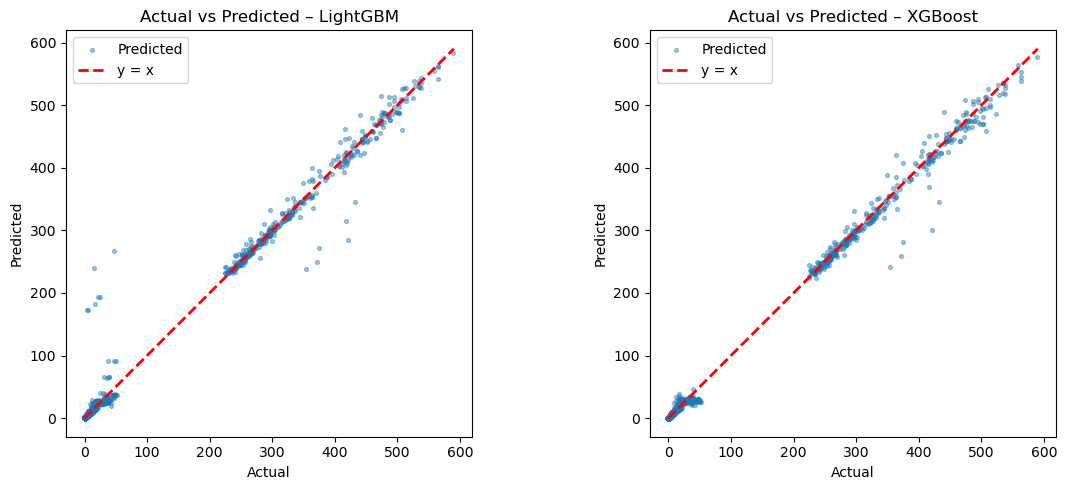

In [6]:
# Scatter actual vs predicted + y=x diagonal (subsample if too many points)
if y_val_actual is not None:
    y_a, pred_lgb, pred_xgb = np.asarray(y_val_actual), np.asarray(y_pred_lgb), np.asarray(y_pred_xgb)
    n_show = min(3000, len(y_a))
    idx = np.random.default_rng(42).choice(len(y_a), size=n_show, replace=False)
    mi, ma = min(y_a.min(), pred_lgb.min(), pred_xgb.min()), max(y_a.max(), pred_lgb.max(), pred_xgb.max())
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    for ax, pred, name in zip(axes, [pred_lgb, pred_xgb], ["LightGBM", "XGBoost"]):
        ax.scatter(y_a[idx], pred[idx], alpha=0.4, s=8, label="Predicted")
        ax.plot([mi, ma], [mi, ma], "r--", lw=2, label="y = x")
        ax.set_xlabel("Actual")
        ax.set_ylabel("Predicted")
        ax.set_title(f"Actual vs Predicted – {name}")
        ax.legend()
        ax.set_aspect("equal")
    plt.tight_layout()
    plt.savefig("../results/figures/validation/scatter_actual_vs_predicted_val.png", dpi=150, bbox_inches="tight")
    plt.show()

## 3.6 Feature Importance

### 3.6.1 LightGBM

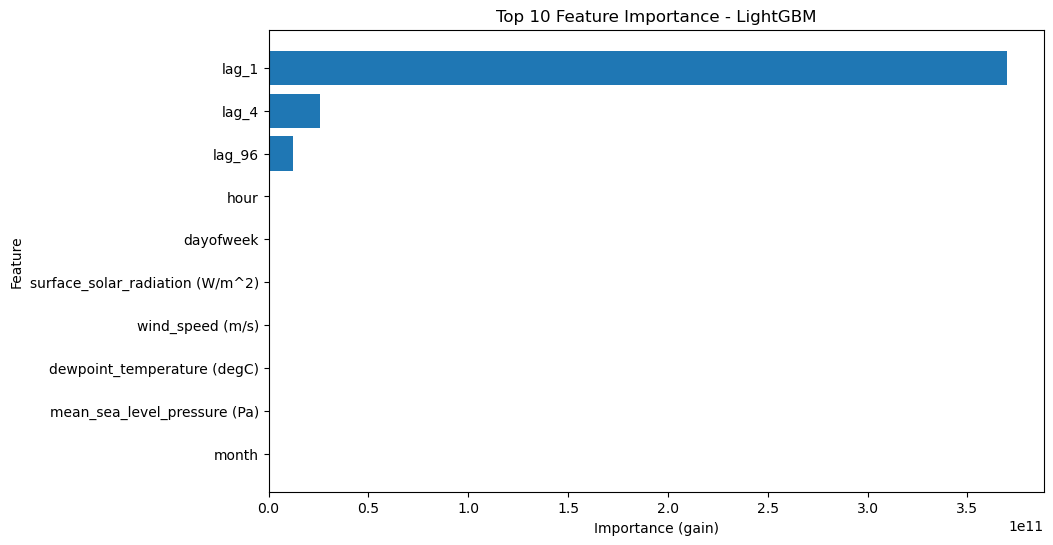

In [7]:
# Get feature importance
lgb_importance_df = pd.DataFrame({
    "feature": feature_cols,
    "importance": lgb_model.feature_importance(importance_type="gain")  # "split" juga bisa
}).sort_values(by="importance", ascending=False)

# Visualize
plt.figure(figsize=(10,6))
plt.barh(lgb_importance_df['feature'][:10][::-1], lgb_importance_df['importance'][:10][::-1])
plt.xlabel("Importance (gain)")
plt.ylabel("Feature")
plt.title("Top 10 Feature Importance - LightGBM")
plt.show()

### 3.6.2 XGBoost

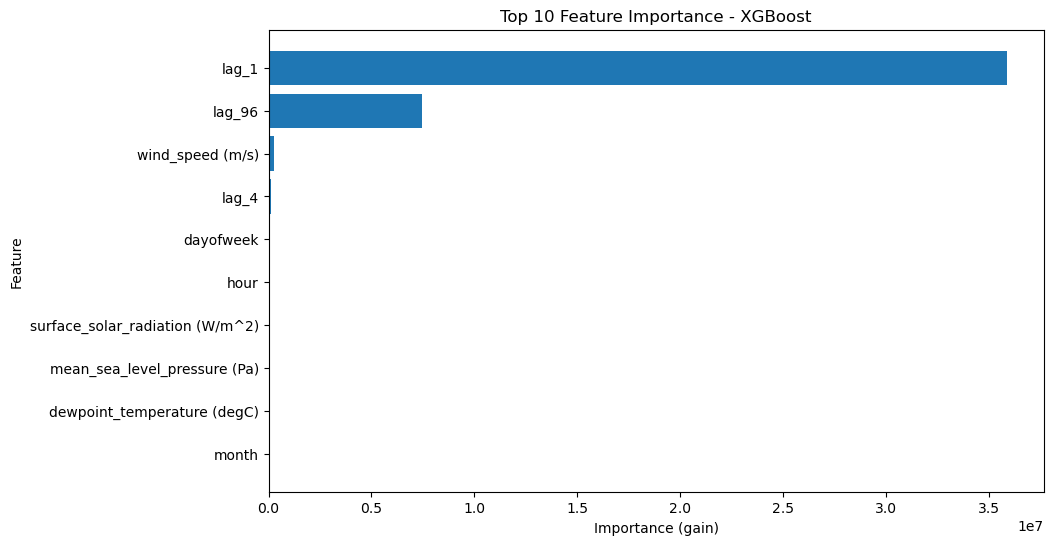

In [8]:
# XGBoost core API feature importance
xgb_importance_dict = xgb_model.get_score(importance_type="gain")
xgb_importance_df = pd.DataFrame({
    "feature": list(xgb_importance_dict.keys()),
    "importance": list(xgb_importance_dict.values())
}).sort_values(by="importance", ascending=False)

# Visualize
plt.figure(figsize=(10,6))
plt.barh(xgb_importance_df['feature'][:10][::-1], xgb_importance_df['importance'][:10][::-1])
plt.xlabel("Importance (gain)")
plt.ylabel("Feature")
plt.title("Top 10 Feature Importance - XGBoost")
plt.show()

## 3.7 Save Model

In [9]:
# -------------------------------
# SAVE MODELS
# -------------------------------

# --- LightGBM core API ---
lgb_model.save_model("../models/lgb_model.txt")  # txt karena core API standar LightGBM

# --- XGBoost core API ---
xgb_model.save_model("../models/xgb_model.json")  # json karena core API XGBoost

# --- Sklearn API alternative (if you used LGBMRegressor / XGBRegressor) ---
# with open("lgb_model.pkl", "wb") as f:
#     pickle.dump(lgb_model, f)
# with open("xgb_model.pkl", "wb") as f:
#     pickle.dump(xgb_model, f)


# -------------------------------
# LOAD MODELS
# -------------------------------

# --- LightGBM ---
lgb_loaded = lgb.Booster(model_file="../models/lgb_model.txt")

# --- XGBoost ---
xgb_loaded = xgb.Booster()
xgb_loaded.load_model("../models/xgb_model.json")

# --- Sklearn API alternative ---
# with open("lgb_model.pkl", "rb") as f:
#     lgb_loaded = pickle.load(f)
# with open("xgb_model.pkl", "rb") as f:
#     xgb_loaded = pickle.load(f)